In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [3]:
LENGTH = 250
BATCH_SIZE = 16

In [4]:
def data_generator():
    """
    Unbounded generation of new data samples, 1 at a time
    """
    while True:
        y = np.zeros(LENGTH)
        i = random.randint(30, LENGTH-30)
        direction = random.choice([False, True])
        
        if direction:
            y[i:] = 1
        else:
            y[:i] = 1

        x = y * 0.5 + 0.2
        if direction:
            x[i:i+10] = 2
        else:
            x[i-10:i] = 2
        x = np.sin(np.cumsum(x)) / 2 + 0.5
        # f1 = np.sin(np.array(range(100)) / 2.0)
        # f2 = np.sin(np.array(range(100)) / 4.0)
        # x = f1 * (y-1) + f2 * y
        yield np.stack([x, 1-x], axis=-1), np.stack([y, 1 - y], axis=-1)

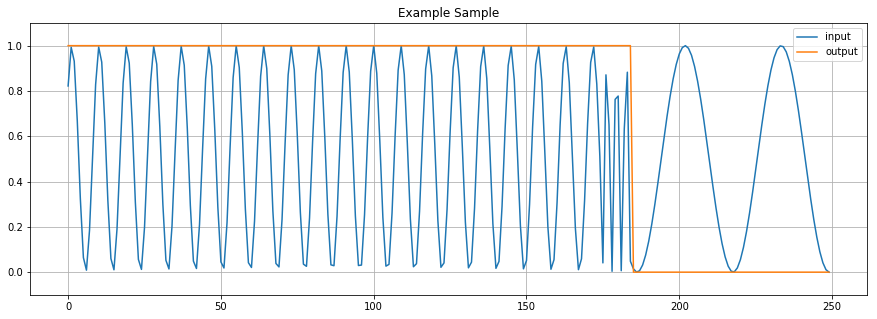

In [5]:
x, y = next(data_generator())
plot(x[:,0], label='input')
plot(y[:,0], label='output')
legend()
grid()
title('Example Sample')
ylim(-0.1, 1.1)
show()

In [6]:
def batch(iterator, batch_size):
    """
    Given an `iterator` which generates 1 sample at a time, batch them up and
    return `batch_size` samples on each yield.
    
    Batch axis will be the first axis.
    """
    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            x, y = next(iterator)
            X.append(x)
            Y.append(y)
        yield np.array(X), np.array(Y)

In [7]:
from tensorflow_hmm.hmm_layer import HMMLayer

Using TensorFlow backend.


In [8]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, InputLayer, Activation
from keras import optimizers

data = batch(data_generator(), BATCH_SIZE)

In [9]:
def make_model(encoder, decoder, loss):
    # create model
    model = Sequential()
    model.add(InputLayer(input_shape=(LENGTH,2)))

    if encoder == 'conv':
        model.add(Conv1D(16, 5, activation='elu', padding='same', strides=1))
        model.add(Conv1D(16, 5, activation='elu', padding='same', strides=1))
    elif encoder == 'lstm':
        model.add(LSTM(16, return_sequences=True))
        model.add(LSTM(16, return_sequences=True))
    else:
        raise ValueError('invalid encoder type: {}'.format(encoder))

    if decoder == 'conv':
        model.add(Conv1D(2, 1, activation='elu', padding='same', strides=1))
    elif decoder == 'lstm':
        model.add(LSTM(2, return_sequences=True))
    else:
        raise ValueError('invalid decoder type: {}'.format(encoder))

    if loss == 'hmm':
        model.add(HMMLayer(states=2, length=LENGTH))
        model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.9))
    elif loss == 'softmax':
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
    else:
        raise ValueError('invalid loss type: {}'.format(encoder))

    return model

In [10]:
def plot_sample_prediction(model, data):
    from tensorflow_hmm import hmm

    X, Y = next(data)

    prediction = model.predict(X)

    # TODO: change keras layer to use viterbi during inference
    # NOTE: this isn't exactly right because if there is an hmm layer, the output prediction has already factored in
    # the transition probability priors
    hmm_np = hmm.HMMNumpy(np.array([[0.99, 0.01], [0.01, 0.99]]), p0=np.array([0.5, 0.5]))
    viterbi, _ = hmm_np.viterbi_decode(prediction[0,:,:])

    print('accuracy: {0:.2f}%'.format(100.0 * sum(Y[0,:,1] == viterbi) / Y.shape[1]))
    print('mean accuracy over mini-batch: {0:.2f}%'.format(np.mean([
        100.0 * sum(Y[i,:,1] == hmm_np.viterbi_decode(prediction[i,:,:])[0]) / Y.shape[1]
        for i in range(Y.shape[0])
    ])))
    plot(viterbi, label='viterbi')
    plot(prediction[0,:,1], label='prediction')
    plot(X[0,:,1], label='input')
    plot(Y[0,:,1], label='truth')
    ylim(-0.1, 1.1)
    grid()
    legend()
    show()

## HMM Loss

In [11]:
model = make_model(encoder='conv', decoder='conv', loss='hmm')
model.fit_generator(data, epochs=5, steps_per_epoch=128)

Epoch 1/5
128/128 [==============================] - 15s 115ms/step - loss: 0.5830
Epoch 2/5
128/128 [==============================] - 9s 68ms/step - loss: 0.0933
Epoch 3/5
128/128 [==============================] - 9s 68ms/step - loss: 0.0196
Epoch 4/5
128/128 [==============================] - 9s 68ms/step - loss: 0.0138
Epoch 5/5
128/128 [==============================] - 9s 68ms/step - loss: 0.0097


/home/ros/data/IPython/tensorflow_hmm/tensorflow_hmm/hmm.py:118: RuntimeWarning: divide by zero encountered in log
  pathScores[0] = self.logp0 + np.log(y[0])
/home/ros/data/IPython/tensorflow_hmm/tensorflow_hmm/hmm.py:125: RuntimeWarning: divide by zero encountered in log
  pathScores[t + 1] = np.max(tmpMat, 0) + np.log(yy)


accuracy: 100.00%
mean accuracy over mini-batch: 99.90%


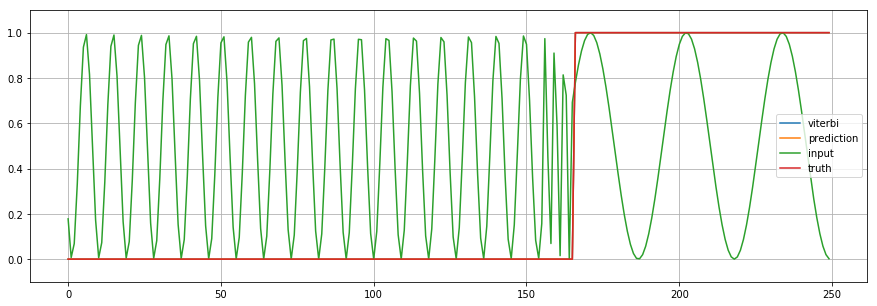

In [12]:
plot_sample_prediction(model, data)

## Softmax + Categorial Cross Entropy Loss

In [13]:
model = make_model(encoder='conv', decoder='conv', loss='softmax')
model.fit_generator(data, epochs=5, steps_per_epoch=128)

Epoch 1/5
128/128 [==============================] - 4s 32ms/step - loss: 0.6388
Epoch 2/5
128/128 [==============================] - 2s 12ms/step - loss: 0.4317
Epoch 3/5
128/128 [==============================] - 2s 13ms/step - loss: 0.3913
Epoch 4/5
128/128 [==============================] - 2s 13ms/step - loss: 0.3735
Epoch 5/5
128/128 [==============================] - 2s 12ms/step - loss: 0.3586


accuracy: 99.60%
mean accuracy over mini-batch: 97.12%


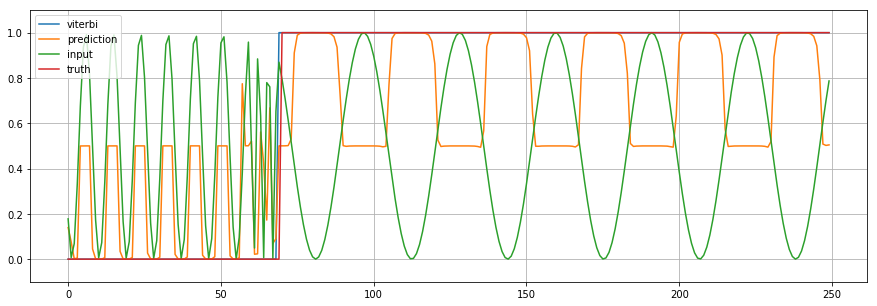

In [14]:
plot_sample_prediction(model, data)